In [ ]:
import gym
from stable_baselines3 import PPO
import torch
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.evaluation import evaluate_policy
from utilsMW.dataLoaderMW import TorchDatasetMWToy
import warnings
from typing import Any, Dict, Optional, Type, Union

import numpy as np
import torch as th
from gym import spaces
from torch.nn import functional as F

from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance,  get_schedule_fn

from searchTest.toyEnvironment import check_outpt
from utilsMW.dataLoaderMW import TorchDatasetMW
from torch.utils.data import DataLoader
from imitation.algorithms.adversarial import gail 

In [ ]:
from active_critic.utils.gym_utils import make_vec_env, make_dummy_vec_env
import gym
from stable_baselines3 import PPO
import torch
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.evaluation import evaluate_policy
from utilsMW.dataLoaderMW import TorchDatasetMWToy
import warnings
from typing import Any, Dict, Optional, Type, Union

import numpy as np
import torch as th
from gym import spaces
from torch.nn import functional as F

from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance,  get_schedule_fn

from searchTest.toyEnvironment import check_outpt
from utilsMW.dataLoaderMW import TorchDatasetMW
from torch.utils.data import DataLoader
from imitation.algorithms.adversarial import gail 
from imitation.util.networks import RunningNorm
from imitation.rewards.reward_nets import BasicRewardNet
from stable_baselines3.ppo import MlpPolicy
from active_critic.utils.tboard_graphs import TBoardGraphs
def sample_expert_transitions(expert, env, num):

    rollouts = rollout.rollout(
        expert,
        env,
        rollout.make_sample_until(min_timesteps=None, min_episodes=num),
        exclude_infos=False,
    )
    return rollout.flatten_trajectories(rollouts), rollouts

def asd(env, learner):
    success = []
    rews = []
    for i in range(100):
        obs = env.reset()
        done = False
        while not done:
            action, _ = learner.predict(obs)
            obs, rew, done, info = env.step(action)
            rews.append(rew)
            if info[0]['success'] > 0:
                success.append(info[0]['success'])
                break
            if done:
                success.append(0)
    return np.array(success), np.array(rews)

from sb3_contrib import TQC
env, vec_expert = make_dummy_vec_env(name='pickplace', seq_len=200)
val_env, _ = make_dummy_vec_env(name='pickplace', seq_len=200)

policy_kwargs = dict(n_critics=2, net_arch=[512,512,512])
learner = TQC("MlpPolicy", env, verbose=1, policy_kwargs=policy_kwargs, buffer_size=1000000, batch_size=2048, gamma=0.95, learning_rate=1e-3, tau=0.05)
learner.use_alt_policy = False
learner.alternative_policy = vec_expert
tboard = TBoardGraphs(logname='TQC without expert Data', data_path='/data/bing/hendrik/gboard/')
for i in range(10000):
    learner.learn(5000, log_interval=1000)
    success, rews = asd(env=val_env, learner=learner)
    tboard.addTrainScalar('Reward', value=th.tensor(rews.mean()), stepid=env.envs[0].reset_count)
    tboard.addTrainScalar('Success Rate', value=th.tensor(success.mean()), stepid=env.envs[0].reset_count)
    print(env.envs[0].reset_count)


In [ ]:
from active_critic.utils.gym_utils import make_vec_env, make_dummy_vec_env
import gym
from stable_baselines3 import PPO
import torch
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.evaluation import evaluate_policy
import warnings
from typing import Any, Dict, Optional, Type, Union

import numpy as np
import torch as th
from gym import spaces
from torch.nn import functional as F

from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance,  get_schedule_fn

from torch.utils.data import DataLoader
from imitation.algorithms.adversarial import gail 
from imitation.util.networks import RunningNorm
from imitation.rewards.reward_nets import BasicRewardNet
from stable_baselines3.ppo import MlpPolicy
from active_critic.utils.tboard_graphs import TBoardGraphs
import argparse
from sb3_contrib import TQC
import copy
def sample_expert_transitions(expert, env, num):

    rollouts = rollout.rollout(
        expert,
        env,
        rollout.make_sample_until(min_timesteps=None, min_episodes=num),
        exclude_infos=False,
    )
    return rollout.flatten_trajectories(rollouts), rollouts

def asd(env, learner):
    success = []
    rews = []
    for i in range(100):
        obs = env.reset()
        done = False
        while not done:
            action, _ = learner.predict(obs)
            obs, rew, done, info = env.step(action)
            rews.append(rew)
            if info[0]['success'] > 0:
                success.append(info[0]['success'])
                break
            if done:
                success.append(0)
    return np.array(success), np.array(rews)

def run_experiment(device):

    env, vec_expert = make_dummy_vec_env(name='pickplace', seq_len=200)
    val_env, _ = make_dummy_vec_env(name='pickplace', seq_len=200)

    transitions, _ = sample_expert_transitions(vec_expert.predict, env, 100)
    env.envs[0].reset_count = 0

    reward_net = BasicRewardNet(
        env.observation_space, env.action_space, normalize_input_layer=RunningNorm)

    policy_kwargs = dict(n_critics=2, net_arch=[512,512,512])
    learner = TQC("MlpPolicy", env, verbose=1, policy_kwargs=policy_kwargs, buffer_size=1000000, batch_size=2048, gamma=0.95, learning_rate=1e-3, tau=0.05, device=device)
    
    gail_trainer = gail.GAIL(
        demonstrations=transitions,
        demo_batch_size=1024,
        gen_replay_buffer_capacity=2048,
        n_disc_updates_per_round=4,
        venv=env,
        gen_algo=learner,
        reward_net=reward_net

    )
    tboard = TBoardGraphs(logname='GAIL + TQC pickplace 100 pure', data_path='/data/bing/hendrik/gboard/')
    current_step = 0
    for i in range(10000):
        gail_trainer.train(1000)
        current_step += 5
        succ, rew = asd(env=val_env, learner=learner)
        print('____________________________________________')
        print(f'succ: {succ.mean()}')
        print(f'rew: {rew.mean()}')
        tboard.addTrainScalar('Reward', value=th.tensor(rew.mean()), stepid=current_step)
        tboard.addTrainScalar('Success Rate', value=th.tensor(succ.mean()), stepid=current_step)



In [ ]:
run_experiment('cuda')

In [ ]:
env, vec_expert = make_dummy_vec_env(name='pickplace', seq_len=200)
val_env, _ = make_dummy_vec_env(name='pickplace', seq_len=200)

transitions, rollouts = sample_expert_transitions(vec_expert.predict, env, 10)
env.envs[0].reset_count = 0

In [ ]:
from active_critic.model_src.transformer import PositionalEncoding
positional_encoding = PositionalEncoding(d_model=10, dropout=0)

In [ ]:
def make_pomdp_rollouts(rollouts, lookup_frq, count_dim):
    inpt = th.zeros([1, rollouts[0].obs.shape[0], count_dim])
    positional_encoding = PositionalEncoding(d_model=10, dropout=0)
    pe = positional_encoding.forward(inpt).numpy()
    for ro in rollouts:
        for i in range(ro.obs.shape[0]):
            if i % lookup_frq == 0:
                obsv = copy.deepcopy(ro.obs[i])
            else:
                ro.obs[i] = copy.deepcopy(obsv)
        ro.obs[:, 20:20+count_dim] = pe
        if i % lookup_frq == 0:
            obs = ro
    return rollouts

In [ ]:
pomdp_rollouts = make_pomdp_rollouts(rollouts, 1, count_dim=10)

In [ ]:
pomdp_transitions = rollout.flatten_trajectories(pomdp_rollouts)

In [ ]:
device = 'cuda'

reward_net = BasicRewardNet(
    env.observation_space, env.action_space, normalize_input_layer=RunningNorm)

policy_kwargs = dict(n_critics=2, net_arch=[512,512,512])
learner = TQC("MlpPolicy", env, verbose=1, policy_kwargs=policy_kwargs, buffer_size=1000000, batch_size=2048, gamma=0.95, learning_rate=1e-3, tau=0.05, device=device)

gail_trainer = gail.GAIL(
        demonstrations=pomdp_transitions,
        demo_batch_size=1024,
        gen_replay_buffer_capacity=2048,
        n_disc_updates_per_round=4,
        venv=env,
        gen_algo=learner,
        reward_net=reward_net

    )
tboard = TBoardGraphs(logname='GAIL + TQC pickplace 100 pomdp', data_path='/data/bing/hendrik/gboard/')
current_step = 0
for i in range(10000):
    gail_trainer.train(1000)
    current_step += 5
    succ, rew = asd(env=val_env, learner=learner)
    print('____________________________________________')
    print(f'succ: {succ.mean()}')
    print(f'rew: {rew.mean()}')
    tboard.addTrainScalar('Reward', value=th.tensor(rew.mean()), stepid=current_step)
    tboard.addTrainScalar('Success Rate', value=th.tensor(succ.mean()), stepid=current_step)

In [ ]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
import seals  # needed to load environments

env = gym.make("seals/CartPole-v0")
expert = PPO(
    policy=MlpPolicy,
    env=env,
    seed=0,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
    n_steps=64,
)
expert.learn(1000)  # Note: set to 100000 to train a proficient expert

from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.util.util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np

rng = np.random.default_rng()
rollouts = rollout.rollout(
    expert,
    make_vec_env(
        "seals/CartPole-v0",
        n_envs=5,
        post_wrappers=[lambda env, _: RolloutInfoWrapper(env)],
    ),
    rollout.make_sample_until(min_timesteps=None, min_episodes=60),
    rng=rng,
)

from imitation.algorithms.adversarial.gail import GAIL
from imitation.rewards.reward_nets import BasicRewardNet
from imitation.util.networks import RunningNorm
from imitation.util.util import make_vec_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv

import gym


venv = make_vec_env("seals/CartPole-v0", n_envs=8)
learner = PPO(
    env=venv,
    policy=MlpPolicy,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
)
reward_net = BasicRewardNet(
    venv.observation_space, venv.action_space, normalize_input_layer=RunningNorm
)
gail_trainer = GAIL(
    demonstrations=rollouts,
    demo_batch_size=1024,
    gen_replay_buffer_capacity=2048,
    n_disc_updates_per_round=4,
    venv=venv,
    gen_algo=learner,
    reward_net=reward_net,
)

learner_rewards_before_training, _ = evaluate_policy(
    learner, venv, 100, return_episode_rewards=True
)
gail_trainer.train(20000)  # Note: set to 300000 for better results
learner_rewards_after_training, _ = evaluate_policy(
    learner, venv, 100, return_episode_rewards=True
)

import matplotlib.pyplot as plt
import numpy as np

print(np.mean(learner_rewards_after_training))
print(np.mean(learner_rewards_before_training))

plt.hist(
    [learner_rewards_before_training, learner_rewards_after_training],
    label=["untrained", "trained"],
)
plt.legend()
plt.show()

In [ ]:
class POMDP_Wrapper(gym.Wrapper):
    def __init__(self, env, lookup_freq, pe_dim, seq_len) -> None:
        super().__init__(env)
        inpt = th.zeros([1, seq_len, pe_dim])

        self.pe = positional_encoding.forward(inpt).numpy()
        self.current_step = 0

    def reset(self):
        obsv =  super().reset()
        obsv[20:30] = self.pe[0, 0]
        self.current_step = 0
        self.current_obv = np.copy(obsv)
        return obsv

    def step(self, action):
        self.current_step += 1
        obsv, rew, done, info = super().step(action)
        
        obsv = np.copy(self.current_obv)
        obsv[20:30] = self.pe[0, self.current_step]

        return obsv, rew, done, info

In [53]:
from active_critic.utils.gym_utils import make_policy_dict, ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE, ResetCounterWrapper, TimeLimit, StrictSeqLenWrapper, ImitationLearningWrapper

def make_dummy_vec_env_pomdp(name, seq_len):
    policy_dict = make_policy_dict()

    env_tag = name
    max_episode_steps = seq_len
    env = ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE[policy_dict[env_tag][1]]()
    env._freeze_rand_vec = False
    reset_env = ResetCounterWrapper(env=env)
    timelimit = TimeLimit(env=reset_env, max_episode_steps=max_episode_steps)
    strict_time = StrictSeqLenWrapper(timelimit, seq_len=seq_len + 1)
    pomdp = POMDP_Wrapper(env=strict_time, lookup_freq=1, pe_dim=10, seq_len=201)

    dv1 = DummyVecEnv([lambda: RolloutInfoWrapper(pomdp)])
    vec_expert = ImitationLearningWrapper(
        policy=policy_dict[env_tag][0], env=dv1)
    return dv1, vec_expert

In [54]:
env, vec_expert = make_dummy_vec_env_pomdp(name='pickplace', seq_len=200)
val_env, _ = make_dummy_vec_env_pomdp(name='pickplace', seq_len=200)

/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [58]:
val_env.reset()

array([[0.00615235, 0.6001898 , 0.19430117, 1.        , 0.00342816,
        0.6789412 , 0.02      , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00604339, 0.5998951 ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.04631111, 0.85237634, 0.17972149]], dtype=float32)

In [59]:
val_env.step(np.array([[1,1,1,1]]))

(array([[6.1523519e-03, 6.0018981e-01, 1.9430117e-01, 1.0000000e+00,
         3.4281577e-03, 6.7894119e-01, 2.0000000e-02, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 6.0433885e-03, 5.9989512e-01,
         8.4147096e-01, 5.4030234e-01, 1.5782663e-01, 9.8746681e-01,
         2.5116224e-02, 9.9968451e-01, 3.9810613e-03, 9.9999207e-01,
         6.3095731e-04, 9.9999982e-01, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         4.6311114e-02, 8.5237634e-01, 1.7972149e-01]], dtype=float32),
 array([0.00643198], dtype=float32),
 array([False]),
 [{'success': 0.0,
   'near_object': 0.0,
   'grasp_success': 0.0,
   'grasp_reward': 0.006674097416744883,
   'in_place_reward': 0.15060142424831546,
   'obj_to_target': 0.23970905102239906,
   'unscaled_reward': 0.006431983414570289}])

In [ ]:
val_env.reset()

In [ ]:
val_env.step(np.array([[1,1,1,1]]))

In [ ]:
transitions[-1]

0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00568 |
|    entropy        | 5.68     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 64.5     |
|    loss           | 4.32     |
|    neglogp        | 4.33     |
|    prob_true_act  | 0.0142   |
|    samples_so_far | 32       |
--------------------------------


474batch [00:01, 272.01batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | -0.00365 |
|    entropy        | 3.65     |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 92.2     |
|    loss           | 1.84     |
|    neglogp        | 1.85     |
|    prob_true_act  | 0.166    |
|    samples_so_far | 16032    |
--------------------------------


994batch [00:03, 277.79batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | -0.00174 |
|    entropy        | 1.74     |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 108      |
|    loss           | 0.0619   |
|    neglogp        | 0.0636   |
|    prob_true_act  | 1.07     |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:04, 276.01batch/s]


0


0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000903 |
|    entropy        | 0.903     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 118       |
|    loss           | -0.568    |
|    neglogp        | -0.567    |
|    prob_true_act  | 2.22      |
|    samples_so_far | 32        |
---------------------------------


476batch [00:01, 270.39batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.000627 |
|    entropy        | -0.627   |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 140      |
|    loss           | -2.03    |
|    neglogp        | -2.03    |
|    prob_true_act  | 10.7     |
|    samples_so_far | 16032    |
--------------------------------


987batch [00:03, 300.62batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00176  |
|    entropy        | -1.76    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 157      |
|    loss           | -2.69    |
|    neglogp        | -2.69    |
|    prob_true_act  | 30.5     |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:04, 283.95batch/s]


0


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00214  |
|    entropy        | -2.14    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 165      |
|    loss           | -2.94    |
|    neglogp        | -2.94    |
|    prob_true_act  | 40       |
|    samples_so_far | 32       |
--------------------------------


497batch [00:01, 288.41batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00279  |
|    entropy        | -2.79    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 178      |
|    loss           | -3.54    |
|    neglogp        | -3.55    |
|    prob_true_act  | 92.8     |
|    samples_so_far | 16032    |
--------------------------------


979batch [00:03, 266.20batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00318  |
|    entropy        | -3.18    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 189      |
|    loss           | -4.35    |
|    neglogp        | -4.35    |
|    prob_true_act  | 127      |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:04, 277.44batch/s]


0


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00335  |
|    entropy        | -3.35    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 194      |
|    loss           | -4.61    |
|    neglogp        | -4.61    |
|    prob_true_act  | 164      |
|    samples_so_far | 32       |
--------------------------------


492batch [00:01, 268.32batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00364  |
|    entropy        | -3.64    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 204      |
|    loss           | -3.78    |
|    neglogp        | -3.78    |
|    prob_true_act  | 171      |
|    samples_so_far | 16032    |
--------------------------------


985batch [00:03, 268.64batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00388  |
|    entropy        | -3.88    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 213      |
|    loss           | -2.92    |
|    neglogp        | -2.92    |
|    prob_true_act  | 269      |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:04, 262.55batch/s]


0


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00398  |
|    entropy        | -3.98    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | -4.63    |
|    neglogp        | -4.63    |
|    prob_true_act  | 245      |
|    samples_so_far | 32       |
--------------------------------


495batch [00:01, 264.74batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00416  |
|    entropy        | -4.16    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 224      |
|    loss           | -2.7     |
|    neglogp        | -2.71    |
|    prob_true_act  | 299      |
|    samples_so_far | 16032    |
--------------------------------


976batch [00:03, 269.50batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00431  |
|    entropy        | -4.31    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 230      |
|    loss           | -4.56    |
|    neglogp        | -4.56    |
|    prob_true_act  | 256      |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:04, 261.43batch/s]


0


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00438  |
|    entropy        | -4.38    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 234      |
|    loss           | -5.29    |
|    neglogp        | -5.3     |
|    prob_true_act  | 403      |
|    samples_so_far | 32       |
--------------------------------


487batch [00:01, 293.65batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0045   |
|    entropy        | -4.5     |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 240      |
|    loss           | -5.63    |
|    neglogp        | -5.64    |
|    prob_true_act  | 476      |
|    samples_so_far | 16032    |
--------------------------------


986batch [00:03, 302.92batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.00459  |
|    entropy        | -4.59    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 245      |
|    loss           | -4.93    |
|    neglogp        | -4.93    |
|    prob_true_act  | 497      |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:04, 282.98batch/s]


0


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.00464  |
|    entropy        | -4.64    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 248      |
|    loss           | -4.47    |
|    neglogp        | -4.48    |
|    prob_true_act  | 410      |
|    samples_so_far | 32       |
--------------------------------


484batch [00:01, 257.52batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.00471  |
|    entropy        | -4.71    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 254      |
|    loss           | -6.17    |
|    neglogp        | -6.17    |
|    prob_true_act  | 628      |
|    samples_so_far | 16032    |
--------------------------------


999batch [00:03, 271.15batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0048   |
|    entropy        | -4.8     |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 260      |
|    loss           | -3.98    |
|    neglogp        | -3.99    |
|    prob_true_act  | 644      |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:04, 275.07batch/s]


KeyboardInterrupt: 

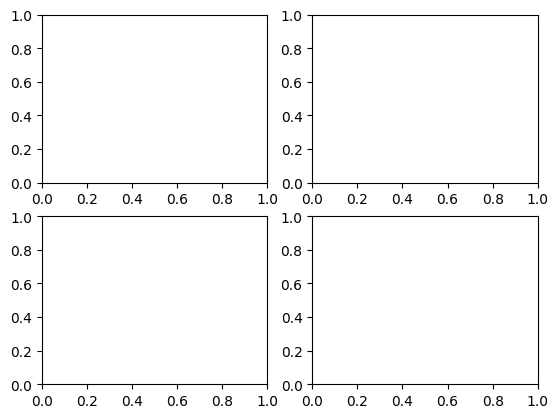

In [60]:
import numpy as np
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.ppo import MlpPolicy

from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper

rng = np.random.default_rng(0)

bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=transitions,
)

tboard = TBoardGraphs(logname='BC pickplace 10', data_path='/data/bing/hendrik/gboard/')
for i in range(10000):
    bc_trainer.train(n_epochs=20)
    success, rews = asd(env=val_env, learner=bc_trainer.policy)
    tboard.addTrainScalar('Reward', value=th.tensor(rews.mean()), stepid=i)
    tboard.addTrainScalar('Success Rate', value=th.tensor(success.mean()), stepid=i)
    print(env.envs[0].reset_count)


In [ ]:
device = 'cuda'
reward_net = BasicRewardNet(
    env.observation_space, env.action_space, normalize_input_layer=RunningNorm)

policy_kwargs = dict(n_critics=2, net_arch=[512,512,512])
learner = TQC("MlpPolicy", env, verbose=1, policy_kwargs=policy_kwargs, buffer_size=1000000, batch_size=2048, gamma=0.95, learning_rate=1e-3, tau=0.05, device=device)

gail_trainer = gail.GAIL(
    demonstrations=transitions,
    demo_batch_size=1024,
    gen_replay_buffer_capacity=2048,
    n_disc_updates_per_round=4,
    venv=env,
    gen_algo=learner,
    reward_net=reward_net

)

In [ ]:
transitions.obsv

In [ ]:
val_env.envs[0].reset_count

In [ ]:
run_experiment(device='cuda:0')


In [ ]:
from active_critic.utils.gym_utils import make_policy_dict

In [ ]:
class asdasd(torch.utils.data.Dataset):
    def __init__(self, asd):
        print('init')
        self.data = torch.arange(10)
        print(len(self.data))

    def __len__(self):
        'Denotes the total number of samples'
        print(len(self.data))
        return len(self.data)

    def __getitem__(self, index):
        'Generates one sample of data'
        return self.data[index]

In [ ]:
path = '/home/hendrik/Documents/master_project/LokalData/metaworld/pick-place/training_data/'
device = 'cuda'
batch_size = 2
#train_data = TorchDatasetMW(path=path, device=device)
train_data = asdasd(asd=1)
train_indices = torch.randperm(int(len(train_data)))
train_indices = train_indices[:int(len(train_indices)*1)]
print(len(train_data))
train_data = torch.utils.data.Subset(train_data, [0])
print(f'len(train_data): {len(train_data)}')
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [ ]:
path_train = '/home/hendrik/Documents/master_project/LokalData/metaworld/small/train/'
path_validate = '/home/hendrik/Documents/master_project/LokalData/metaworld/small/val/'
train_data = TorchDatasetMWToy(path=path_train, device='cpu')
val_data = TorchDatasetMWToy(path=path_validate, device='cpu')
print(train_data.data.shape)
print(train_data.label.shape)

In [ ]:
train_data.data.size(0)

In [ ]:
import stable_baselines3

In [ ]:
env = gym.make("CartPole-v1")
env.metadata

In [ ]:
global SAMPLED_ENVS
global STEPS_TAKEN
SAMPLED_ENVS = 0
STEPS_TAKEN = 0

In [ ]:
class my_env():
    def __init__(self):
        #obs = step, data, action, current_env
        self.observation_space = gym.spaces.box.Box(np.array([0, -2,-2,-2,-2, 0,0,0,0.,0]), np.array([6, 2,2,2,2, 1,1,1,1.,train_data.data.size(0)]), (10,), float)
        #next state (4)
        self.action_space = gym.spaces.box.Box(np.array([0,0,0,0]), np.array([1,1,1,1]), (4,), float)
        self.metadata = {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
        self.steps = 0
        self.current_env = -1
        self.data = train_data.data
        self.label = train_data.label
        self.traj = None
        self.num_envs = 1
    def reset(self):
        global SAMPLED_ENVS
        global STEPS_TAKEN
        STEPS_TAKEN += 1
        SAMPLED_ENVS += 1
        self.traj = None
        self.current_env = (self.current_env + 1)%len(self.data)
        self.steps = 0
        last_action = torch.zeros(4, dtype=float, device=self.data.device)
        step = torch.tensor(self.steps, device=self.data.device)
        current_env = torch.tensor(self.current_env, device=self.data.device)
        data = self.data[self.current_env, 0]
        #label = self.label[self.current_env,0]
        state = torch.cat((step.view(1), data, last_action, current_env.view(1)), dim=0).numpy()
        #print(f'reset: {state.shape}')
        return state

    def step(self, action):
        global STEPS_TAKEN
        STEPS_TAKEN += 1
        if type(action) is np.ndarray:
            action = torch.tensor(action, device=self.data.device)
        if self.traj is None:
            self.traj = action.reshape(1,-1)
        else:
            self.traj = torch.cat((self.traj, action.reshape(1,-1)), dim=0)



        self.steps += 1
        step = torch.tensor(self.steps, device=self.data.device)
        current_env = torch.tensor(self.current_env, device=self.data.device)

        #label = self.label[self.current_env, self.current_step]
        data = self.data[self.current_env, 0]

        state = torch.cat((step.view(1), data, action.reshape(-1), current_env.view(1)), dim=0).numpy()
        #print(f'step: {state.shape}')

        if self.steps >= self.label.size(1):
            tol_neg = -0.55*torch.ones([self.traj.size(-1)])
            tol_pos = 0.7*torch.ones([self.traj.size(-1)])
            reward = int(check_outpt(self.label[self.current_env].unsqueeze(0), self.traj.unsqueeze(0), tol_neg=tol_neg, tol_pos=tol_pos))
            return (state, reward, True, {})
        else:
            return (state, 0., False, {})

    def close(self):
        pass
    
    def render(self, mode):
        pass

class toy_exper_model(OnPolicyAlgorithm):
    def __init__(
            self,
            policy: Union[str, Type[ActorCriticPolicy]] = 'MlpPolicy',
            env: Union[GymEnv, str] = None,
            learning_rate: Union[float, Schedule] = 3e-4,
            n_steps: int = 2048,
            batch_size: int = 64,
            n_epochs: int = 10,
            gamma: float = 0.99,
            gae_lambda: float = 0.95,
            clip_range: Union[float, Schedule] = 0.2,
            clip_range_vf: Union[None, float, Schedule] = None,
            normalize_advantage: bool = True,
            ent_coef: float = 0.0,
            vf_coef: float = 0.5,
            max_grad_norm: float = 0.5,
            use_sde: bool = False,
            sde_sample_freq: int = -1,
            target_kl: Optional[float] = None,
            tensorboard_log: Optional[str] = None,
            create_eval_env: bool = False,
            policy_kwargs: Optional[Dict[str, Any]] = None,
            verbose: int = 0,
            seed: Optional[int] = None,
            device: Union[th.device, str] = "auto",
            _init_setup_model: bool = True,
            train_data = None
        ):
        super().__init__(
            policy,
            env,
            learning_rate=learning_rate,
            n_steps=n_steps,
            gamma=gamma,
            gae_lambda=gae_lambda,
            ent_coef=ent_coef,
            vf_coef=vf_coef,
            max_grad_norm=max_grad_norm,
            use_sde=use_sde,
            sde_sample_freq=sde_sample_freq,
            tensorboard_log=tensorboard_log,
            policy_kwargs=policy_kwargs,
            verbose=verbose,
            device=device,
            create_eval_env=create_eval_env,
            seed=seed,
            _init_setup_model=False,
            supported_action_spaces=(
                spaces.Box,
                spaces.Discrete,
                spaces.MultiDiscrete,
                spaces.MultiBinary,
            ),
        )
        self.data = train_data.data
        self.label = train_data.label
        #obs = step, data, action, current_env
        self.observation_space = gym.spaces.box.Box(np.array([0, -2,-2,-2,-2, 0,0,0,0.,0]), np.array([6, 2,2,2,2, 1,1,1,1.,train_data.data.size(0)]), (10,), float)
        #next state (4)
        self.action_space = gym.spaces.box.Box(np.array([0,0,0,0]), np.array([1,1,1,1]), (4,), float)

    def predict(self, obs, state=None, episode_start=None, deterministic=False):
        step = int(obs.reshape(-1)[0])
        env = int(obs.reshape(-1)[-1])
        #print(f'expert: {self.label[env, step].reshape(1, -1).shape}')
        return self.label[env, step].reshape(1, -1), self.label[env, step].reshape(1, -1)


In [ ]:
toy_env = my_env(train_data=train_data)
val_env = my_env(train_data=val_data)
my_expert = toy_exper_model(train_data=train_data, env=env)

In [ ]:
def sample_expert_transitions():
    expert = my_expert

    print("Sampling expert transitions.")
    rollouts = ro.rollout(
        expert,
        DummyVecEnv([lambda: RolloutInfoWrapper(toy_env)]),
        ro.make_sample_until(min_timesteps=None, min_episodes=10000),
    )
    return ro.flatten_trajectories(rollouts)

In [ ]:
transitions = sample_expert_transitions()

In [ ]:
# @author Simon Stepputtis <sstepput@asu.edu>, Interactive Robotics Lab, Arizona State University

from pickle import NONE
from urllib.parse import non_hierarchical
#matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from hashids import Hashids
import cv2
import os



class TBoardGraphsTorch():
    def __init__(self, logname= None, data_path = None):
        if logname is not None:
            self.__hashids           = Hashids()
            #self.logdir              = "Data/TBoardLog/" + logname + "/"
            self.logdir              = os.path.join(data_path, "gboard/" + logname + "/")
            print(f'log dir: {self.logdir + "train/"}')
            self.__tboard_train      = tf.summary.create_file_writer(self.logdir + "train/")
            self.__tboard_validation = tf.summary.create_file_writer(self.logdir + "validate/")
            #self.voice               = Voice(path=data_path)
        self.fig, self.ax = plt.subplots(3,3)

    def startDebugger(self):
        tf.summary.trace_on(graph=True, profiler=True)
    
    def stopDebugger(self):
        with self.__tboard_validation.as_default():
            tf.summary.trace_export(name="model_trace", step=0, profiler_outdir=self.logdir)

    def finishFigure(self, fig):
        fig.canvas.draw()
        data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        return data
    
    def addTrainScalar(self, name, value, stepid):
        with self.__tboard_train.as_default():
            tfvalue = self.torch2tf(value)
            tf.summary.scalar(name, tfvalue, step=stepid)

    def addValidationScalar(self, name, value, stepid):
        with self.__tboard_validation.as_default():
            tfvalue = self.torch2tf(value)
            tf.summary.scalar(name, tfvalue, step=stepid)

    def torch2tf(self, inpt):
        if inpt is not None:
            return tf.convert_to_tensor(inpt.detach().cpu().numpy())
        else:
            return inpt

    def plotTrajectory(self, y_true, y_pred, dt_true, dt_pred, stepid):
        tf_y_true = self.torch2tf(y_true)
        tf_y_pred = self.torch2tf(y_pred)
        tf_dt_true = self.torch2tf(dt_true)
        tf_dt_pred = self.torch2tf(dt_pred)

        fig, ax = plt.subplots(3,3)
        fig.set_size_inches(9, 9)

        tf_dt_true = 1.0/tf_dt_true.numpy()
        tf_dt_pred = 1.0/tf_dt_pred.numpy()[0]

        max_trj_len = tf_y_true.shape[0]
        for sp in range(7):
            idx = sp // 3
            idy = sp  % 3
            ax[idx,idy].clear()
            ax[idx,idy].plot(range(max_trj_len), tf_y_pred[:,sp], alpha=0.5, color='midnightblue')
            ax[idx,idy].plot(range(max_trj_len), tf_y_true[:,sp], alpha=0.5, color='forestgreen')
            # ax[idx,idy].plot([dt_pred, dt_pred], [-0.1, 1.1], alpha=0.5, linestyle=":", color="midnightblue")
            # ax[idx,idy].plot([dt_true, dt_true], [-0.1, 1.1], alpha=0.5, linestyle=":", color="forestgreen")
            # ax[idx,idy].set_ylim([-0.1, 1.1])

        result = np.expand_dims(self.finishFigure(fig), 0)
        plt.close()
        with self.__tboard_validation.as_default():
            tf.summary.image("Trajectory", data=result, step=stepid)

    def idToText(self, id):
        names = ["", "ysr", "rsr", "gsr", "bsr", "psr", "ylr", "rlr", "glr", "blr", "plr", "yss", "rss", "gss", "bss", "pss", "yls", "rls", "gls", "bls", "pls"]
        return names[id]

    def plotImageRegions(self, image, image_dict, stepid):
        # Visualization of the results of a detection.
        num_detected = len([v for v in image_dict["detection_scores"][0] if v > 0.5]) 
        image_np     = image.numpy()       
        for i in range(num_detected):
            ymin, xmin, ymax, xmax = image_dict['detection_boxes'][0][i,:]
            pt1 = (int(xmin*image_np.shape[1]), int(ymin*image_np.shape[0]))
            pt2 = (int(xmax*image_np.shape[1]), int(ymax*image_np.shape[0]))
            image_np = cv2.rectangle(image_np, pt1, pt2, (255, 0, 0), 2)
            image_np = cv2.putText(image_np, self.idToText(image_dict['detection_classes'][0][i]) + " {:.1f}%".format(image_dict["detection_scores"][0][i] * 100), pt1, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1, cv2.LINE_AA)

        fig = plt.figure()
        plt.imshow(image_np)

        result = np.expand_dims(self.finishFigure(fig), 0)
        plt.close()
        with self.__tboard_validation.as_default():
            tf.summary.image("Image", data=result, step=stepid)

    def plotAttention(self, attention_weights, image_dict, language, stepid):
        tf_attention_weights = self.torch2tf(attention_weights)
        tf_language = self.torch2tf(language)

        tf_attention_weights = tf_attention_weights.numpy()
        classes           = image_dict["detection_classes"][0][:len(tf_attention_weights)].numpy().astype(dtype=np.int32)
        classes           = [self.idToText(i) for i in classes]
        x                 = np.arange(len(tf_attention_weights))
        
        fig, ax = plt.subplots()
        plt.bar(x, tf_attention_weights)
        plt.xticks(x, classes)
        ax.set_ylim([0, 1])
        plt.text(0.01, 0.95, self.voice.tokensToSentence(tf_language.numpy().tolist()), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

        result = np.expand_dims(self.finishFigure(fig), 0)
        plt.close()
        with self.__tboard_validation.as_default():
            tf.summary.image("Attention", data=result, step=stepid)
    
    def plotClassAccuracy(self, gt_class, pred_class, pred_class_std, language, stepid):
        labels     = ["ysr", "rsr", "gsr", "bsr", "psr", "ylr", "rlr", "glr", "blr", "plr", "yss", "rss", "gss", "bss", "pss", "yls", "rls", "gls", "bls", "pls"]
        tf_gt_class = self.torch2tf(gt_class)
        tf_pred_class = self.torch2tf(pred_class)
        tf_language = self.torch2tf(language)

        
        
        tf_gt_class   = tf_gt_class.numpy()
        tf_pred_class = tf_pred_class.numpy()
        x          = np.arange(len(tf_gt_class))
        width      = 0.35
        
        fig, ax = plt.subplots()
        #rects1 = ax.bar(x - width/2, gt_class, width, label='GT', color="forestgreen")
        #rects2 = ax.bar(x + width/2, pred_class, width, yerr=pred_class_std, label='Pred', color="midnightblue")
        ax.set_xticks(x)
        # ax.set_xticklabels(labels)
        plt.text(0.01, 0.95, self.voice.tokensToSentence(tf_language.numpy().tolist()), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

        result = np.expand_dims(self.finishFigure(fig), 0)
        plt.close()
        with self.__tboard_validation.as_default():
            tf.summary.image("Attention", data=result, step=stepid)

    def plotDeltaT(self, y_true, y_pred, stepid):
        tf_y_true = self.torch2tf(y_true)
        tf_y_pred = self.torch2tf(y_pred)

        gt = tf_y_true.numpy()
        pd = tf_y_pred.numpy()[:,0]
        jdata = np.stack((gt,pd), axis=1)
        svals = jdata[np.argsort(jdata[:,0]),:]
        x     = np.arange(svals.shape[0])
        width = 0.35
        
        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width/2, svals[:,0], width, label='GT', color="forestgreen")
        rects2 = ax.bar(x + width/2, svals[:,1], width, label='Pred', color="midnightblue")
        ax.set_xticks(x)

        result = np.expand_dims(self.finishFigure(fig), 0)
        plt.close()
        with self.__tboard_validation.as_default():
            tf.summary.image("DeltaT", data=result, step=stepid)

    def plotWeights(self, gt_w, pred_w, stepid):
        tf_gt_w = self.torch2tf(gt_w)
        tf_pred_w = self.torch2tf(pred_w)

        fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,sharex=True)
        # fig.set_size_inches(4, 10)

        combined_weights = np.concatenate((tf_gt_w.numpy(), tf_pred_w.numpy()), axis=0).T

        ax1.imshow(combined_weights[:,:7], cmap="RdBu")
        ax2.imshow(combined_weights[:,7:], cmap="RdBu")

        result = np.expand_dims(self.finishFigure(fig), 0)
        plt.close()
        with self.__tboard_validation.as_default():
            tf.summary.image("Weights", data=result, step=stepid)

    def interpolateTrajectory(self, trj, target):
        tf_trj = self.torch2tf(trj)
        tf_target = self.torch2tf(target)

        current_length = tf_trj.shape[0]
        dimensions     = tf_trj.shape[1]
        result         = np.zeros((tf_target, dimensions), dtype=np.float32)
    
        for i in range(dimensions):
            result[:,i] = np.interp(np.linspace(0.0, 1.0, num=tf_target), np.linspace(0.0, 1.0, num=current_length), trj[:,i])
        
        return result

    def plotDMPTrajectory(self, y_true, y_pred, y_pred_std = None, phase= None, \
        dt= None, p_dt= None, stepid= None, name = "Trajectory", save = False, \
            name_plot = None, path=None, tol_neg = None, tol_pos=None, inpt = None, opt_gen_trj=None, window = 0):
        tf_y_true = self.torch2tf(y_true)
        tf_y_pred = self.torch2tf(y_pred)
        tf_phase = self.torch2tf(phase)
        tf_inpt = self.torch2tf(inpt)
        if p_dt is not None:
            tf_dt = self.torch2tf(dt)
            tf_p_dt = self.torch2tf(p_dt)
        if opt_gen_trj is not None:
            tf_opt_gen_trj = self.torch2tf(opt_gen_trj)
            tf_opt_gen_trj = tf_opt_gen_trj.numpy()

        tf_y_true      = tf_y_true.numpy()
        tf_y_pred      = tf_y_pred.numpy()
        tf_inpt        = tf_inpt.numpy()
        if tf_phase is not None:
            tf_phase       = tf_phase.numpy()

        if p_dt is not None:
            tf_dt          = tf_dt.numpy() * 350.0
            tf_p_dt        = tf_p_dt.numpy()
        trj_len      = tf_y_true.shape[0]
        
        #fig, ax = plt.subplots(3,3)
        fig, ax = self.fig, self.ax
        #fig.set_size_inches(9, 9)
        neg_inpt = tf_y_true + tol_neg[None,:].cpu().numpy()
        pos_inpt = tf_y_true + tol_pos[None,:].cpu().numpy()
        for sp in range(len(tf_y_true[0])):
            idx = sp // 3
            idy = sp  % 3
            ax[idx,idy].clear()

            # GT Trajectory:
            if tol_neg is not None:

                ax[idx,idy].plot(range(tf_y_pred.shape[0]), neg_inpt[:,sp], alpha=0.75, color='orangered')
                ax[idx,idy].plot(range(tf_y_pred.shape[0]), pos_inpt[:,sp], alpha=0.75, color='orangered')
            ax[idx,idy].plot(range(trj_len), tf_y_true[:,sp],   alpha=1.0, color='forestgreen')            
            ax[idx,idy].plot(range(tf_y_pred.shape[0]), tf_y_pred[:,sp], alpha=0.75, color='mediumslateblue')
            if opt_gen_trj is not None:
                ax[idx,idy].plot(range(tf_y_pred.shape[0]), tf_opt_gen_trj[:,sp], alpha=0.75, color='lightseagreen')
                diff_vec = tf_opt_gen_trj - tf_y_pred
                ax[idx,idy].plot(range(tf_y_pred.shape[0]), diff_vec[:,sp], alpha=0.75, color='pink')

            #ax[idx,idy].errorbar(range(tf_y_pred.shape[0]), tf_y_pred[:,sp], xerr=None, yerr=None, alpha=0.25, fmt='none', color='mediumslateblue')
            #ax[idx,idy].set_ylim([-0.1, 1.1])
            if p_dt is not None:
                ax[idx,idy].plot([tf_dt, tf_dt], [0.0,1.0], linestyle=":", color='forestgreen')

        if inpt is not None:
            ax[-1,-1].clear()
            ax[-1,-1].plot(range(inpt.shape[-1]), tf_inpt,   alpha=1.0, color='forestgreen')     
        
        if tf_phase is not None:
            ax[2,2].clear()
            ax[2,2].plot(range(tf_y_pred.shape[0]), tf_phase, color='orange')
        if p_dt is not None:
            ax[2,2].plot([tf_dt, tf_dt], [0.0,1.0], linestyle=":", color='forestgreen')
            ax[2,2].plot([tf_p_dt*350.0, tf_p_dt*350.0], [0.0,1.0], linestyle=":", color='mediumslateblue')
            ax[2,2].set_ylim([-0.1, 1.1])

        result = np.expand_dims(self.finishFigure(fig), 0)
        if save:
            if not os.path.exists(path):
                os.makedirs(path)
            plt.savefig(path + name_plot + '.png')
        #fig.clear()
        #plt.close()
        if not save:
            with self.__tboard_validation.as_default():
                tf.summary.image(name, data=result, step=stepid)

In [ ]:
from hashids import Hashids
import tensorflow as tf
import matplotlib.pyplot as plt
tboard = TBoardGraphsTorch(logname='asd', data_path='/home/hendrik/Documents/master_project/LokalData/test/')

In [ ]:
from imitation.policies import *
policy = ActorCriticPolicy(observation_space=toy_env.observation_space, action_space=toy_env.action_space, lr_schedule=lambda _: torch.finfo(torch.float32).max, net_arch = [dict(pi=[200, 200], vf=[200, 200])])

In [ ]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
count_parameters(policy)

In [ ]:
bc_trainer = bc.BC(
    observation_space=toy_env.observation_space,
    action_space=toy_env.action_space,
    demonstrations=transitions,
    policy=policy,
    device='cpu'
)
#bc_trainer.train(n_epochs=300)

In [ ]:
from active_critic.utils.gym_utils import make_vec_env, make_dummy_vec_env
import gym
from stable_baselines3 import PPO
import torch
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.evaluation import evaluate_policy
from utilsMW.dataLoaderMW import TorchDatasetMWToy
import warnings
from typing import Any, Dict, Optional, Type, Union

import numpy as np
import torch as th
from gym import spaces
from torch.nn import functional as F

from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance,  get_schedule_fn

from searchTest.toyEnvironment import check_outpt
from utilsMW.dataLoaderMW import TorchDatasetMW
from torch.utils.data import DataLoader
from imitation.algorithms.adversarial import gail 
from active_critic.utils.gym_utils import make_policy_dict

In [ ]:
from active_critic.policy.active_critic_policy import ActiveCriticPolicy
import numpy as np
import torch as th
from metaworld.envs import \
    ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE
from metaworld.policies import *
from gym.wrappers import TimeLimit
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from active_critic.utils.rollout import rollout, make_sample_until, flatten_trajectories
from stable_baselines3.common.type_aliases import GymEnv
from gym import Env
import gym
import torch.nn as nn
import numpy as np
import math
import torch
class reset_counter(gym.Wrapper):
    def __init__(self, env: Env) -> None:
        super().__init__(env)
        self.reset_count = 0

    def reset(self):
        self.reset_count+=1
        return super().reset()

In [ ]:
env, vec_expert = make_dummy_vec_env(name='pickplace', seq_len=200)

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


In [ ]:
pr = PositionalEncoding(d_model=14, dropout=0)

In [ ]:
class ResetCounterWrapper(gym.Wrapper):
    def __init__(self, env: Env) -> None:
        super().__init__(env)
        self.reset_count = 0

    def reset(self):
        self.reset_count+=1
        return super().reset()

    def step(self, action):
        
        obsv, rew, done, info = super().step(action)
        return obsv, rew, done, info
    
class ImitationLearningWrapper:
    def __init__(self, policy, env: GymEnv):
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.policy = policy

    def predict(self, obsv, deterministic=None):
        actions = []
        for obs in obsv:
            actions.append(self.policy.get_action(obs))
        return actions
    
class NoLookupWrapper(gym.Wrapper):
    def __init__(self, env: Env, seq_len) -> None:
        super().__init__(env)
        self.obsv = None
        self.seq_len = seq_len
        self.current_step = 0
        self.pe = None
        self.succes = 0
        self.not_grade = False
        self.current_obsv = None

    def reset(self):
        obsv = super().reset()

        if self.pe is None:
            if (obsv.shape[-1] % 2 ) != 0:
                self.not_grade = True
                d_model = obsv.shape[-1] + 1
            else:
                d_model = obsv.shape[-1]
            self.act_d_model = obsv.shape[-1]
            self.pe = PositionalEncoding(d_model=d_model, dropout=0)
        if self.not_grade:
            n_obsv = np.concatenate((obsv, np.zeros_like(obsv)[...,:1]), axis=-1)
        else:
            n_obsv = obsv
        self.obsv = th.tensor(n_obsv)
        self.obsv = self.obsv.reshape([1, 1, -1]).repeat([1, self.seq_len, 1])
        self.obsv = self.pe.forward(self.obsv)
        self.current_obsv = obsv.reshape([1,-1])
        return self.obsv[0, 0, :self.act_d_model].numpy()

    def step(self, action):
        print(action)
        obsv, rew, done, info = super().step(action)
        self.current_step += 1
        if rew == 10:
            self.succes = 10
        self.current_obsv = obsv.reshape([1,-1])
        #return self.obsv[0, self.current_step, :self.act_d_model].numpy(), self.succes, done, info
        return obsv, self.succes, done, info
        

In [ ]:
def make_dummy_vec_env(name, seq_len):
    policy_dict = make_policy_dict()

    env_tag = name
    max_episode_steps = seq_len
    env = ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE[policy_dict[env_tag][1]]()
    env._freeze_rand_vec = False
    reset_env = ResetCounterWrapper(env=env)
    timelimit = TimeLimit(env=reset_env, max_episode_steps=max_episode_steps)
    #sparse_lookup = NoLookupWrapper(timelimit, seq_len=seq_len)

    dv1 = DummyVecEnv([lambda: RolloutInfoWrapper(timelimit)])
    vec_expert = ImitationLearningWrapper(
        policy=policy_dict[env_tag][0], env=dv1)
    return dv1, vec_expert

In [ ]:
val_env, expert = make_dummy_vec_env(name='pickplace', seq_len=200)

In [ ]:
from imitation.data import rollout

In [ ]:
def sample_expert_transitions(venv, expert):

    print("Sampling expert transitions.")
    rollouts = rollout.rollout(
        expert,
        venv,
        rollout.make_sample_until(min_timesteps=None, min_episodes=20),
    )
    return rollout.flatten_trajectories(rollouts)

In [ ]:
transitions = sample_expert_transitions(venv=val_env, expert=expert.predict)

In [ ]:
val_env.reset()

In [ ]:
val_env.step(np.array([[0,0,0,0]]))

In [ ]:
def sample_expert_transitions(expert, env, num):

    rollouts = rollout.rollout(
        expert,
        env,
        rollout.make_sample_until(min_timesteps=None, min_episodes=num),
        exclude_infos=False,
    )
    return rollout.flatten_trajectories(rollouts), rollouts

In [ ]:
transitions, rollouts = sample_expert_transitions(vec_expert.predict, env=env, num=10)

In [ ]:
def asd(env, learner):
    success = []
    rews = []
    for i in range(500):
        obs = env.reset()
        done = False
        while not done:
            action, _ = learner.predict(obs)
            obs, rew, done, info = env.step(action)
            rews.append(rew)
            if info[0]['success'] > 0:
                success.append(info[0]['success'])
                break
            if done:
                success.append(0)
    return np.array(success), np.array(rews)

In [ ]:
from imitation.algorithms import bc

bc_trainer = bc.BC(
    observation_space=val_env.observation_space,
    action_space=val_env.action_space,
    demonstrations=transitions,
)

In [ ]:
tboard = TBoardGraphs(logname='BC pickplace 10', data_path='/data/bing/hendrik/gboard/')

In [ ]:
for i in range(100000):
    succ, rew = asd(val_env, bc_trainer.policy)
    print(f'succ: {succ.mean()}')
    tboard.addValidationScalar('Success Rate', th.tensor(succ.mean()), stepid=i)
    bc_trainer.train(n_epochs=1, log_interval=100000000000000000)

In [ ]:
env.envs[0].reset_count

In [ ]:
from imitation.util.networks import RunningNorm
from imitation.rewards.reward_nets import BasicRewardNet
from stable_baselines3.ppo import MlpPolicy

In [ ]:
import numpy as np

In [ ]:
from sb3_contrib import TQC
from active_critic.utils.gym_utils import make_vec_env, make_dummy_vec_env


In [ ]:
tqc = TQC.load('/home/hendrik/Documents/master_project/LokalData/push_tqc.zip')
val_env, _ = make_dummy_vec_env(name='push', seq_len=200)

In [ ]:
sucess, rew = asd(val_env, tqc)

In [ ]:
sucess[:3]

In [ ]:
import torch as th
a = th.rand([4,3,1])
b = a.squeeze().max(dim=-1).values
b

In [ ]:
from imitation.algorithms import bc

bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=transitions,
)

In [ ]:
from sb3_contrib import TQC

policy_kwargs = dict(n_critics=2, n_quantiles=25)
learner = TQC("MlpPolicy", env, top_quantiles_to_drop_per_net=2, verbose=1, policy_kwargs=policy_kwargs)

In [ ]:
learner.use_alt_policy = False
learner.alternative_policy = vec_expert

In [ ]:
env.envs[0].reset_count

In [ ]:
from active_critic.utils.tboard_graphs import TBoardGraphs

In [ ]:
from active_critic.utils.gym_utils import make_vec_env, make_dummy_vec_env
import gym
from stable_baselines3 import PPO
import torch
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.evaluation import evaluate_policy
from utilsMW.dataLoaderMW import TorchDatasetMWToy
import warnings
from typing import Any, Dict, Optional, Type, Union

import numpy as np
import torch as th
from gym import spaces
from torch.nn import functional as F

from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance,  get_schedule_fn

from searchTest.toyEnvironment import check_outpt
from utilsMW.dataLoaderMW import TorchDatasetMW
from torch.utils.data import DataLoader
from imitation.algorithms.adversarial import gail 
from imitation.util.networks import RunningNorm
from imitation.rewards.reward_nets import BasicRewardNet
from stable_baselines3.ppo import MlpPolicy
from active_critic.utils.tboard_graphs import TBoardGraphs
def sample_expert_transitions(expert, env, num):

    rollouts = rollout.rollout(
        expert,
        env,
        rollout.make_sample_until(min_timesteps=None, min_episodes=num),
        exclude_infos=False,
    )
    return rollout.flatten_trajectories(rollouts), rollouts

def asd(env, learner):
    success = []
    rews = []
    for i in range(100):
        obs = env.reset()
        done = False
        while not done:
            action, _ = learner.predict(obs)
            obs, rew, done, info = env.step(action)
            rews.append(rew)
            if info[0]['success'] > 0:
                success.append(info[0]['success'])
                break
            if done:
                success.append(0)
    return np.array(success), np.array(rews)

from sb3_contrib import TQC
env, vec_expert = make_dummy_vec_env(name='pickplace', seq_len=200)
val_env, _ = make_dummy_vec_env(name='pickplace', seq_len=200)

policy_kwargs = dict(n_critics=2, net_arch=[512,512,512])
learner = TQC("MlpPolicy", env, verbose=1, policy_kwargs=policy_kwargs, buffer_size=1000000, batch_size=2048, gamma=0.95, learning_rate=1e-3, tau=0.05)
tboard = TBoardGraphs(logname='TQC with expert Data', data_path='/data/bing/hendrik/gboard/')
for i in range(10000):
    learner.learn(1000, log_interval=1000)
    success, rews = asd(env=val_env, learner=learner)
    tboard.addTrainScalar('Reward', value=th.tensor(rews.mean()), stepid=env.envs[0].reset_count)
    tboard.addTrainScalar('Success Rate', value=th.tensor(success.mean()), stepid=env.envs[0].reset_count)


In [ ]:
for i in range(10000):
    learner.learn(1000, log_interval=1000)
    success, rews = asd(env=val_env, learner=learner)
    tboard.addTrainScalar('Reward', value=th.tensor(rews.mean()), stepid=env.envs[0].reset_count)
    tboard.addTrainScalar('Success Rate', value=th.tensor(success.mean()), stepid=env.envs[0].reset_count)


In [ ]:
reward_net = BasicRewardNet(
    env.observation_space, env.action_space, normalize_input_layer=RunningNorm
)
from active_critic.utils.gym_utils import make_vec_env, make_dummy_vec_env
import gym
from stable_baselines3 import PPO
import torch
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.evaluation import evaluate_policy
from utilsMW.dataLoaderMW import TorchDatasetMWToy
import warnings
from typing import Any, Dict, Optional, Type, Union

import numpy as np
import torch as th
from gym import spaces
from torch.nn import functional as F

from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance,  get_schedule_fn

from searchTest.toyEnvironment import check_outpt
from utilsMW.dataLoaderMW import TorchDatasetMW
from torch.utils.data import DataLoader
from imitation.algorithms.adversarial import gail 
from imitation.util.networks import RunningNorm
from imitation.rewards.reward_nets import BasicRewardNet
from stable_baselines3.ppo import MlpPolicy
from active_critic.utils.tboard_graphs import TBoardGraphs
def sample_expert_transitions(expert, env, num):

    rollouts = rollout.rollout(
        expert,
        env,
        rollout.make_sample_until(min_timesteps=None, min_episodes=num),
        exclude_infos=False,
    )
    return rollout.flatten_trajectories(rollouts), rollouts

def asd(env, learner):
    success = []
    rews = []
    for i in range(100):
        obs = env.reset()
        done = False
        while not done:
            action, _ = learner.predict(obs)
            obs, rew, done, info = env.step(action)
            rews.append(rew)
            if info[0]['success'] > 0:
                success.append(info[0]['success'])
                break
            if done:
                success.append(0)
    return np.array(success), np.array(rews)

from sb3_contrib import TQC
env, vec_expert = make_dummy_vec_env(name='pickplace', seq_len=200)
val_env, _ = make_dummy_vec_env(name='pickplace', seq_len=200)

policy_kwargs = dict(n_critics=2, net_arch=[512,512,512])
learner = TQC("MlpPolicy", env, verbose=1, policy_kwargs=policy_kwargs, buffer_size=1000000, batch_size=2048, gamma=0.95, learning_rate=1e-3, tau=0.05)
tboard = TBoardGraphs(logname='TQC with expert Data', data_path='/data/bing/hendrik/gboard/')
for i in range(10000):
    learner.learn(1000, log_interval=1000)
    success, rews = asd(env=val_env, learner=learner)
    tboard.addTrainScalar('Reward', value=th.tensor(rews.mean()), stepid=env.envs[0].reset_count)
    tboard.addTrainScalar('Success Rate', value=th.tensor(success.mean()), stepid=env.envs[0].reset_count)

gail_trainer = gail.GAIL(
    demonstrations=transitions,
    demo_batch_size=1024,
    gen_replay_buffer_capacity=2048,
    n_disc_updates_per_round=4,
    venv=env,
    gen_algo=learner,
    reward_net=reward_net,
)

In [ ]:
env.envs[0].reset_count = 0

In [ ]:
gail_trainer.set_demonstrations(transitions)

In [ ]:
for i in range(1):
    gail_trainer.train(1000)
    _, next_rollouts = sample_expert_transitions(vec_expert.predict, env=env, num=100)
    rollouts = rollouts + next_rollouts
    transitions = rollout.flatten_trajectories(rollouts)
    gail_trainer.set_demonstrations(transitions)
    _, rews = asd(env=env, learner=learner)
    print(f'rews: {rews.mean()}')

In [ ]:
_, rews = asd(env=env, learner=learner)
print(f'rews: {rews.mean()}')

In [ ]:
env.envs[0].reset_count

In [ ]:
from active_critic.utils.gym_utils import make_vec_env, make_dummy_vec_env
import gym
from stable_baselines3 import PPO
import torch
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.evaluation import evaluate_policy
from utilsMW.dataLoaderMW import TorchDatasetMWToy
import warnings
from typing import Any, Dict, Optional, Type, Union

import numpy as np
import torch as th
from gym import spaces
from torch.nn import functional as F

from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance,  get_schedule_fn

from searchTest.toyEnvironment import check_outpt
from utilsMW.dataLoaderMW import TorchDatasetMW
from torch.utils.data import DataLoader
from imitation.algorithms.adversarial import gail 
from imitation.util.networks import RunningNorm
from imitation.rewards.reward_nets import BasicRewardNet
from stable_baselines3.ppo import MlpPolicy
from active_critic.utils.tboard_graphs import TBoardGraphs
def sample_expert_transitions(expert, env, num):

    rollouts = rollout.rollout(
        expert,
        env,
        rollout.make_sample_until(min_timesteps=None, min_episodes=num),
        exclude_infos=False,
    )
    return rollout.flatten_trajectories(rollouts), rollouts

def asd(env, learner):
    success = []
    rews = []
    for i in range(100):
        obs = env.reset()
        done = False
        while not done:
            action, _ = learner.predict(obs)
            obs, rew, done, info = env.step(action)
            rews.append(rew)
            if info[0]['success'] > 0:
                success.append(info[0]['success'])
                break
            if done:
                success.append(0)
    return np.array(success), np.array(rews)

from sb3_contrib import TQC
env, vec_expert = make_dummy_vec_env(name='pickplace', seq_len=200)
val_env, _ = make_dummy_vec_env(name='pickplace', seq_len=200)

policy_kwargs = dict(n_critics=2, net_arch=[512,512,512])
learner = TQC("MlpPolicy", env, verbose=1, policy_kwargs=policy_kwargs, buffer_size=1000000, batch_size=2048, gamma=0.95, learning_rate=1e-3, tau=0.05)
tboard = TBoardGraphs(logname='TQC with expert Data', data_path='/data/bing/hendrik/gboard/')
for i in range(10000):
    learner.learn(1000, log_interval=1000)
    success, rews = asd(env=val_env, learner=learner)
    tboard.addTrainScalar('Reward', value=th.tensor(rews.mean()), stepid=env.envs[0].reset_count)
    tboard.addTrainScalar('Success Rate', value=th.tensor(success.mean()), stepid=env.envs[0].reset_count)


In [ ]:
np.array(rews).mean()

In [ ]:
np.array(rews).mean()

In [ ]:
success

In [ ]:
Gail_Trainer = gail.GAIL(demonstrations=transitions, )

In [ ]:
tboard = TBoardGraphsTorch(logname='asd', data_path='/home/hendrik/Documents/master_project/LokalData/test/')
for i in range(100):
    rew = []
    for j in range(1000):
        obs = val_env.reset()
        done = False
        while not done:
            action, _ = bc_trainer.policy.predict(obs)
            obs, reward, done, _ = val_env.step(action=action)
        rew.append(reward)
    reward = torch.tensor(rew).type(torch.float).mean()
    print(reward)
    tboard.addValidationScalar('success rate', reward.detach(), stepid=i)
    target_trj = val_env.label[val_env.current_env]
    gen_trj = val_env.traj
    inpt = val_env.data[val_env.current_env][0]

    tol_neg = -0.55*torch.ones([val_env.traj.size(-1)])
    tol_pos = 0.7*torch.ones([val_env.traj.size(-1)])
    tboard.plotDMPTrajectory(target_trj, gen_trj, torch.zeros_like(gen_trj),
                                None, None, None, stepid=i, save=False, name_plot='imitation baseline', path='',\
                                    tol_neg=tol_neg, tol_pos=tol_pos, inpt = inpt, name='imitation baseline', opt_gen_trj = None, window=None)
    bc_trainer.train(n_epochs=5)


In [ ]:
from stable_baselines3.common.env_util import make_vec_env
vec_toy_env = make_vec_env(my_env, n_envs=1)from active_critic.utils.gym_utils import make_vec_env, make_dummy_vec_env
import gym
from stable_baselines3 import PPO
import torch
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.evaluation import evaluate_policy
from utilsMW.dataLoaderMW import TorchDatasetMWToy
import warnings
from typing import Any, Dict, Optional, Type, Union

import numpy as np
import torch as th
from gym import spaces
from torch.nn import functional as F

from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance,  get_schedule_fn

from searchTest.toyEnvironment import check_outpt
from utilsMW.dataLoaderMW import TorchDatasetMW
from torch.utils.data import DataLoader
from imitation.algorithms.adversarial import gail 
from imitation.util.networks import RunningNorm
from imitation.rewards.reward_nets import BasicRewardNet
from stable_baselines3.ppo import MlpPolicy
from active_critic.utils.tboard_graphs import TBoardGraphs
def sample_expert_transitions(expert, env, num):

    rollouts = rollout.rollout(
        expert,
        env,
        rollout.make_sample_until(min_timesteps=None, min_episodes=num),
        exclude_infos=False,
    )
    return rollout.flatten_trajectories(rollouts), rollouts

def asd(env, learner):
    success = []
    rews = []
    for i in range(100):
        obs = env.reset()
        done = False
        while not done:
            action, _ = learner.predict(obs)
            obs, rew, done, info = env.step(action)
            rews.append(rew)
            if info[0]['success'] > 0:
                success.append(info[0]['success'])
                break
            if done:
                success.append(0)
    return np.array(success), np.array(rews)

from sb3_contrib import TQC
env, vec_expert = make_dummy_vec_env(name='pickplace', seq_len=200)
val_env, _ = make_dummy_vec_env(name='pickplace', seq_len=200)

policy_kwargs = dict(n_critics=2, net_arch=[512,512,512])
learner = TQC("MlpPolicy", env, verbose=1, policy_kwargs=policy_kwargs, buffer_size=1000000, batch_size=2048, gamma=0.95, learning_rate=1e-3, tau=0.05)
tboard = TBoardGraphs(logname='TQC with expert Data', data_path='/data/bing/hendrik/gboard/')
for i in range(10000):
    learner.learn(1000, log_interval=1000)
    success, rews = asd(env=val_env, learner=learner)
    tboard.addTrainScalar('Reward', value=th.tensor(rews.mean()), stepid=env.envs[0].reset_count)
    tboard.addTrainScalar('Success Rate', value=th.tensor(success.mean()), stepid=env.envs[0].reset_count)

SAMPLED_ENVS = 0
STEPS_TAKEN = 0

In [ ]:
import copy

In [ ]:
policy.save('backup')


In [ ]:
policy.load('backup')


In [ ]:
SAMPLED_ENVS = 0
STEPS_TAKEN = 0
rein_model = PPO("MlpPolicy", vec_toy_env, verbose=0, learning_rate=1e-4)
rein_model.policy = policy
rein_model.policy.to(rein_model.device)

for i in range(100):
    rein_model.learn(total_timesteps=1000)
    print_reward(rein_model.policy)

In [ ]:
SAMPLED_ENVS

In [ ]:
STEPS_TAKEN

In [ ]:
def print_reward(policy, logname = 'ppo'):
    tboard = TBoardGraphsTorch(logname=logname, data_path='/home/hendrik/Documents/master_project/LokalData/stableBaselines/')
    rew = []
    for j in range(1000):from active_critic.utils.gym_utils import make_vec_env, make_dummy_vec_env
import gym
from stable_baselines3 import PPO
import torch
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.evaluation import evaluate_policy
from utilsMW.dataLoaderMW import TorchDatasetMWToy
import warnings
from typing import Any, Dict, Optional, Type, Union

import numpy as np
import torch as th
from gym import spaces
from torch.nn import functional as F

from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance,  get_schedule_fn

from searchTest.toyEnvironment import check_outpt
from utilsMW.dataLoaderMW import TorchDatasetMW
from torch.utils.data import DataLoader
from imitation.algorithms.adversarial import gail 
from imitation.util.networks import RunningNorm
from imitation.rewards.reward_nets import BasicRewardNet
from stable_baselines3.ppo import MlpPolicy
from active_critic.utils.tboard_graphs import TBoardGraphs
def sample_expert_transitions(expert, env, num):

    rollouts = rollout.rollout(
        expert,
        env,
        rollout.make_sample_until(min_timesteps=None, min_episodes=num),
        exclude_infos=False,
    )
    return rollout.flatten_trajectories(rollouts), rollouts

def asd(env, learner):
    success = []
    rews = []
    for i in range(100):
        obs = env.reset()
        done = False
        while not done:
            action, _ = learner.predict(obs)
            obs, rew, done, info = env.step(action)
            rews.append(rew)
            if info[0]['success'] > 0:
                success.append(info[0]['success'])
                break
            if done:
                success.append(0)
    return np.array(success), np.array(rews)

from sb3_contrib import TQC
env, vec_expert = make_dummy_vec_env(name='pickplace', seq_len=200)
val_env, _ = make_dummy_vec_env(name='pickplace', seq_len=200)

policy_kwargs = dict(n_critics=2, net_arch=[512,512,512])
learner = TQC("MlpPolicy", env, verbose=1, policy_kwargs=policy_kwargs, buffer_size=1000000, batch_size=2048, gamma=0.95, learning_rate=1e-3, tau=0.05)
tboard = TBoardGraphs(logname='TQC with expert Data', data_path='/data/bing/hendrik/gboard/')
for i in range(10000):
    learner.learn(1000, log_interval=1000)
    success, rews = asd(env=val_env, learner=learner)
    tboard.addTrainScalar('Reward', value=th.tensor(rews.mean()), stepid=env.envs[0].reset_count)
    tboard.addTrainScalar('Success Rate', value=th.tensor(success.mean()), stepid=env.envs[0].reset_count)

        obs = val_env.reset()
        done = False
        while not done:
            action, _ = policy.predict(obs)
            obs, reward, done, _ = val_env.step(action=action)
        rew.append(reward)
    reward = torch.tensor(rew).type(torch.float).mean()
    print(f'num_envs: {SAMPLED_ENVS}')
    print(reward)
    tboard.addValidationScalar('success rate', reward.detach(), stepid=i)
    target_trj = val_env.label[val_env.current_env]
    gen_trj = val_env.traj
    inpt = val_env.data[val_env.current_env][0]

    tol_neg = -0.55*torch.ones([val_env.traj.size(-1)])
    tol_pos = 0.7*torch.ones([val_env.traj.size(-1)])
    tboard.plotDMPTrajectory(target_trj, gen_trj, torch.zeros_like(gen_trj),
                                None, None, None, stepid=i, save=False, name_plot='ppo fine tuning baseline', path='',\
                                    tol_neg=tol_neg, tol_pos=tol_pos, inpt = inpt, name='ppo fine tuning baseline', opt_gen_trj = None, window=None)


In [ ]:
for i in range(100):
    rew = []
    for j in range(1000):
        obs = val_env.reset()
        done = False
        while not done:
            action, _ = bc_trainer.policy.predict(obs)
            obs, reward, done, _ = val_env.step(action=action)
        rew.append(reward)
    reward = torch.tensor(rew).type(torch.float).mean()
    print(reward)
    tboard.addValidationScalar('success rate', reward.detach(), stepid=i)
    target_trj = val_env.label[val_env.current_env]
    gen_trj = val_env.traj
    inpt = val_env.data[val_env.current_env][0]

    tol_neg = -0.55*torch.ones([val_env.traj.size(-1)])
    tol_pos = 0.7*torch.ones([val_env.traj.size(-1)])
    tboard.plotDMPTrajectory(target_trj, gen_trj, torch.zeros_like(gen_trj),
                                None, None, None, stepid=i, save=False, name_plot='imitation baseline', path='',\
                                    tol_neg=tol_neg, tol_pos=tol_pos, inpt = inpt, name='imitation baseline', opt_gen_trj = None, window=None)
    bc_trainer.train(n_epochs=5)

In [ ]:
import torch
import scipy.stats
from torch import Tensor

In [ ]:
class ConvergenceDetector():
    def __init__(self, model_setup, model_constructor) -> None:
        self.model_constructor = model_constructor
        self.loss_history = None
        self.mean_loss_history = []

    def add_loss(self, loss, setup, set_meta):
        if self.loss_history is None:
            self.loss_history = loss
        else:
            self.loss_history = torch.cat((self.loss_history, loss))
        if self.detect_convergence():
            setup()
            set_meta()

    def torch_compute_confidence_interval(self, data: Tensor,
                                           confidence: float = 0.95
                                           ) -> Tensor:
        """
        Computes the confidence interval for a given survey of a data set.
        """
        n = len(data)
        mean: Tensor = data.mean()
        # se: Tensor = scipy.stats.sem(data)  # compute standard error
        # se, mean: Tensor = torch.std_mean(data, unbiased=True)  # compute standard error
        se: Tensor = data.std(unbiased=True) / (n**0.5)
        t_p: float = float(scipy.stats.t.ppf((1 + confidence) / 2., n - 1))
        ci = t_p * se
        return mean, ci

    def detect_convergence(self):
        self.mean_loss_history.append(self.torch_compute_confidence_interval(data=self.loss_history))
        if len(self.mean_loss_history) > 1:
            converged = True
            for mean_loss in self.mean_loss_history[-5:-1]:
                if (mean_loss[0] > (self.mean_loss_history[-1][0] + self.mean_loss_history[-1][1])):
                    converged = False
            return converged
        else:
            return False

In [ ]:
cd = ConvergenceDetector(None, None)

In [ ]:
cd.loss_history = torch.randn(1000)
print(cd.detect_convergence())
print(cd.detect_convergence())
cd.loss_history = torch.randn(1000) - 1
print('_______________')
print(cd.detect_convergence())
print(cd.mean_loss_history)


In [ ]:
cd.mean_loss_history

In [ ]:
from active_critic.utils.gym_utils import make_vec_env, make_dummy_vec_env
import gym
from stable_baselines3 import PPO
import torch
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.evaluation import evaluate_policy
from utilsMW.dataLoaderMW import TorchDatasetMWToy
import warnings
from typing import Any, Dict, Optional, Type, Union

import numpy as np
import torch as th
from gym import spaces
from torch.nn import functional as F

from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance,  get_schedule_fn

from searchTest.toyEnvironment import check_outpt
from utilsMW.dataLoaderMW import TorchDatasetMW
from torch.utils.data import DataLoader
from imitation.algorithms.adversarial import gail 
from imitation.util.networks import RunningNorm
from imitation.rewards.reward_nets import BasicRewardNet
from stable_baselines3.ppo import MlpPolicy
from active_critic.utils.tboard_graphs import TBoardGraphs
def sample_expert_transitions(expert, env, num):

    rollouts = rollout.rollout(
        expert,
        env,
        rollout.make_sample_until(min_timesteps=None, min_episodes=num),
        exclude_infos=False,
    )
    return rollout.flatten_trajectories(rollouts), rollouts

def asd(env, learner):
    success = []
    rews = []
    for i in range(100):
        obs = env.reset()
        done = False
        while not done:
            action, _ = learner.predict(obs)
            obs, rew, done, info = env.step(action)
            rews.append(rew)
            if info[0]['success'] > 0:
                success.append(info[0]['success'])
                break
            if done:
                success.append(0)
    return np.array(success), np.array(rews)

from sb3_contrib import TQC
env, vec_expert = make_dummy_vec_env(name='pickplace', seq_len=200)
val_env, _ = make_dummy_vec_env(name='pickplace', seq_len=200)

policy_kwargs = dict(n_critics=2, net_arch=[512,512,512])
learner = TQC("MlpPolicy", env, verbose=1, policy_kwargs=policy_kwargs, buffer_size=1000000, batch_size=2048, gamma=0.95, learning_rate=1e-3, tau=0.05)
tboard = TBoardGraphs(logname='TQC with expert Data', data_path='/data/bing/hendrik/gboard/')
for i in range(10000):
    learner.learn(1000, log_interval=1000)
    success, rews = asd(env=val_env, learner=learner)
    tboard.addTrainScalar('Reward', value=th.tensor(rews.mean()), stepid=env.envs[0].reset_count)
    tboard.addTrainScalar('Success Rate', value=th.tensor(success.mean()), stepid=env.envs[0].reset_count)
